In [1]:
import os
import pandas as pd

import re
import time
import random
import string
from typing import Any

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42
ROOT_DIR = '../datasets/'

In [3]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
seed_all(RANDOM_SEED)

In [4]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))

In [39]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0


## Sensitive topic

In [40]:
# Load model directly
import json

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("apanc/russian-sensitive-topics")
model = AutoModelForSequenceClassification.from_pretrained("apanc/russian-sensitive-topics")

with open("./data/id2topic.json") as f:
    target_vaiables_id2topic_dict = json.load( f)

# Adjust the output of the model
def adjust_multilabel(y):
    for y_c in y:
        index = str(int(np.argmax(y_c)))
        y_c = target_vaiables_id2topic_dict[index]
    return y_c

# Sensitive data classifier
def classify_text(text):
    tokenized = tokenizer.batch_encode_plus([text],
                                            max_length=512,
                                            padding='longest',
                                            truncation=True,
                                            return_token_type_ids=False)
    tokens_ids, mask = torch.tensor(tokenized['input_ids']), torch.tensor(tokenized['attention_mask'])
    with torch.no_grad():
        model_output = model(tokens_ids, mask)
    preds = adjust_multilabel(model_output['logits'])  # Replace with your actual adjustment function
    return preds

In [46]:
# Apply the classification function to each row in the 'Content' column
train_df['Sensitive Topic'] = train_df['Content'].apply(classify_text)

/Users/danylovanin/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/danylovanin/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave m

In [47]:
# Apply the classification function to each row in the 'Content' column
test_df['Sensitive Topic'] = test_df['Content'].apply(classify_text)

/Users/danylovanin/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0


In [48]:
test_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Sensitive Topic
0,ukraina_ru,1175084215,168641,2023-09-11 16:57:36,2023-09-11 16:57:50,"⚡️Администрация Байдена близка к тому, чтобы о...","weapons,politics"
1,bear007,1505866568,36569,2023-09-11 14:52:01,2023-09-11 14:52:12,РИА Новости публикует первые кадры с места гиб...,"offline_crime,politics"
2,zakharprilepin,1217080686,19697,2023-09-11 08:26:09,NaN,Вице-спикер Госдумы Петр Толстой - о сроках ок...,"terrorism,politics"
3,denazi_ua,1783083983,49296,2023-09-11 12:30:37,2023-09-11 12:32:55,В Германии не осталось действующих специалисто...,weapons
4,spletnicca,1287596810,11784,2023-09-11 08:47:19,NaN,Военные медики рассказали правду о войне и её ...,politics


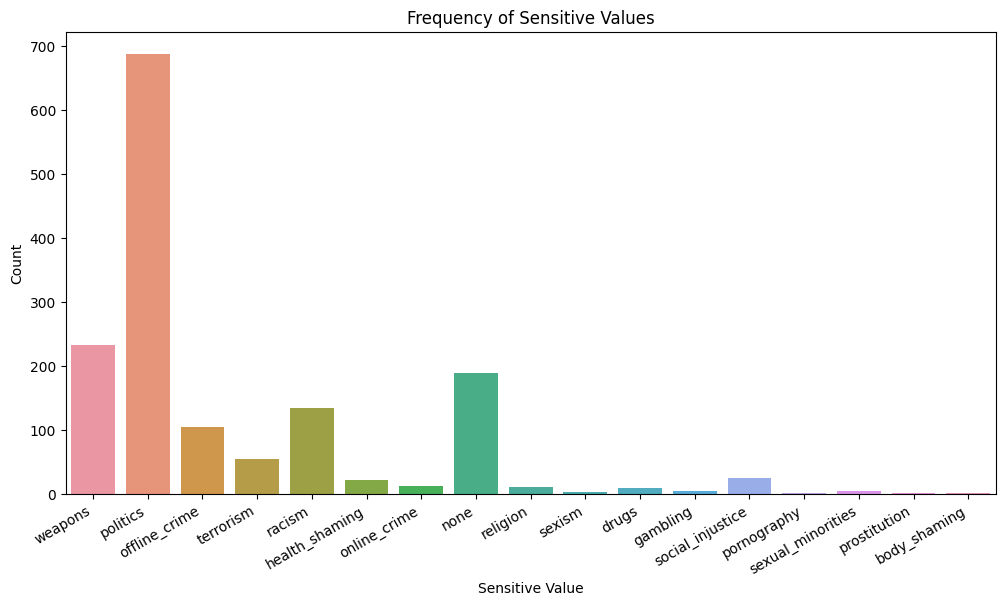

In [51]:
import seaborn as sns

# Split comma-separated values and create a new DataFrame
test_split_df = test_df['Sensitive Topic'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Sensitive_Value')

# Create a bar plot without separating based on 'Suspicious_Level'
plt.figure(figsize=(12, 6))
sns.countplot(x='Sensitive_Value', data=test_split_df)
plt.title('Frequency of Sensitive Values')
plt.xlabel('Sensitive Value')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')  # Rotate x-axis labels by 30 degrees
plt.show()

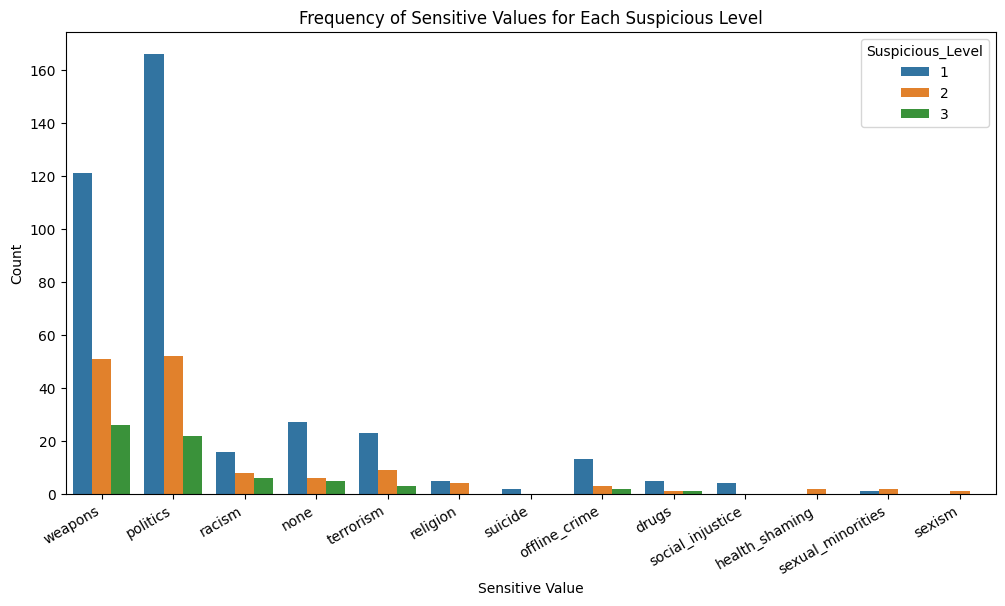

In [54]:
import seaborn as sns
# Split comma-separated values and create a new DataFrame
train_split_df = train_df['Sensitive Topic'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Sensitive_Value')

# Merge the split values with the original DataFrame
train_merged_df = pd.merge(train_df, train_split_df, left_index=True, right_index=True)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Sensitive_Value', hue='Suspicious_Level', data=train_merged_df)
plt.title('Frequency of Sensitive Values for Each Suspicious Level')
plt.xlabel('Sensitive Value')
plt.ylabel('Count')

# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=30, ha='right')

plt.show()


In [28]:
# Count the number of comma-separated values in 'Sensitive Topic' and store in 'num_sensitive'
train_df['num_sensitive'] = train_df['Sensitive Topic'].apply(lambda x: 0 if x == 'none' else len(x.split(',')))


In [168]:
# Count the number of comma-separated values in 'Sensitive Topic' and store in 'num_sensitive'
test_df['num_sensitive'] = test_df['Sensitive Topic'].apply(lambda x: 0 if x == 'none' else len(x.split(',')))


In [35]:
# Assuming you have already created 'num_sensitive' and 'Suspicious_Level' columns in train_df
correlation = train_df['num_sensitive'].corr(train_df['Suspicious_Level'], method='spearman')

print(f"Correlation between num_sensitive and Suspicious_Level: {correlation}")

Correlation between num_sensitive and Suspicious_Level: 0.17092594237470127


## Sentiment

In [55]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

sentiment_tokenizer = AutoTokenizer.from_pretrained("seara/rubert-base-cased-russian-sentiment")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-base-cased-russian-sentiment")

In [91]:
from transformers import pipeline
sentiment_analyzer = pipeline(model="seara/rubert-base-cased-russian-sentiment")
sentiment_analyzer("Привет, ты мне нравишься!")
# [{'label': 'positive', 'score': 0.9818321466445923}]


[{'label': 'positive', 'score': 0.9818321466445923}]

In [120]:
# Function to predict sentiment
def predict_sentiment(text):

    max_sequence_length = sentiment_tokenizer.model_max_length
    truncated_text = text[:512]

    # Make the prediction using the pipeline
    result = sentiment_analyzer(truncated_text)

    # Extract the predicted label
    predicted_label = result[0]['label']
    sentiment_score = result[0]['score']

    return {'Sentiment': predicted_label, 'Sentiment_score': sentiment_score}


In [121]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
predictions = train_df['Content'].apply(predict_sentiment)

# Extract 'Sentiment' and 'Sentiment_Score' into separate columns
train_df['Sentiment'] = predictions.apply(lambda x: x['Sentiment'])
train_df['Sentiment_Score'] = predictions.apply(lambda x: x['Sentiment_score'])

In [123]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1,neutral,0.973560
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881


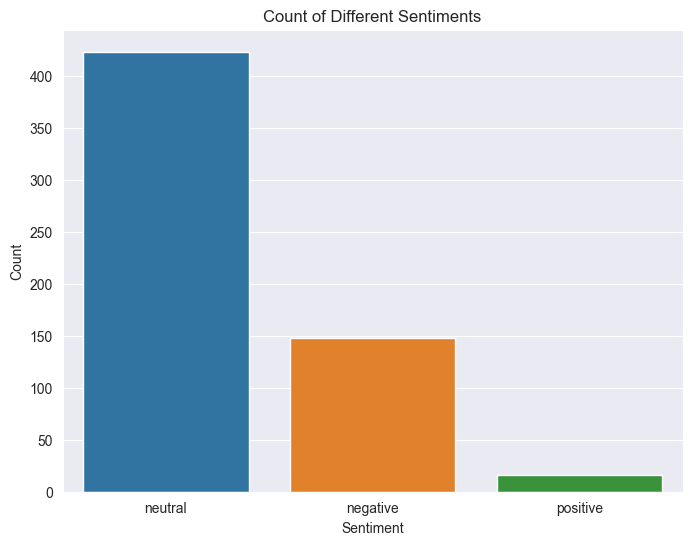

In [124]:
# Assuming 'train_df' is a DataFrame with 'Sentiment' column
sentiment_counts = train_df['Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=train_df, order=sentiment_counts.index)
plt.title('Count of Different Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

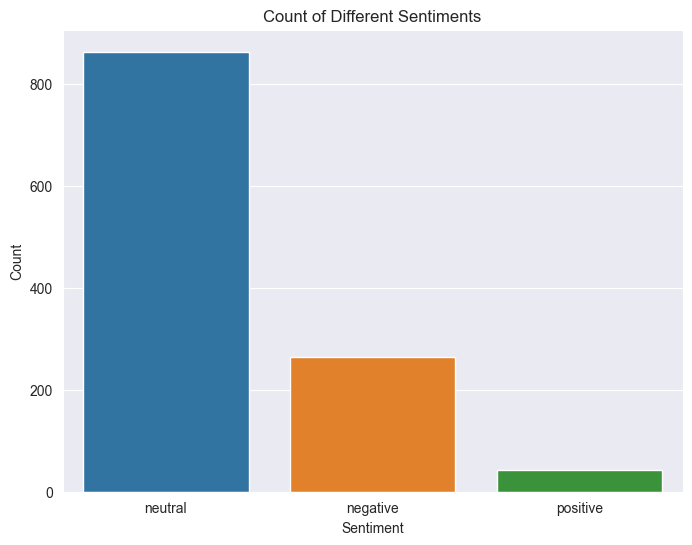

In [125]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
test_predictions = test_df['Content'].apply(predict_sentiment)

# Extract 'Sentiment' and 'Sentiment_Score' into separate columns
test_df['Sentiment'] = test_predictions.apply(lambda x: x['Sentiment'])
test_df['Sentiment_Score'] = test_predictions.apply(lambda x: x['Sentiment_score'])

# Assuming 'train_df' is a DataFrame with 'Sentiment' column
test_sentiment_counts = test_df['Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=test_df, order=test_sentiment_counts.index)
plt.title('Count of Different Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

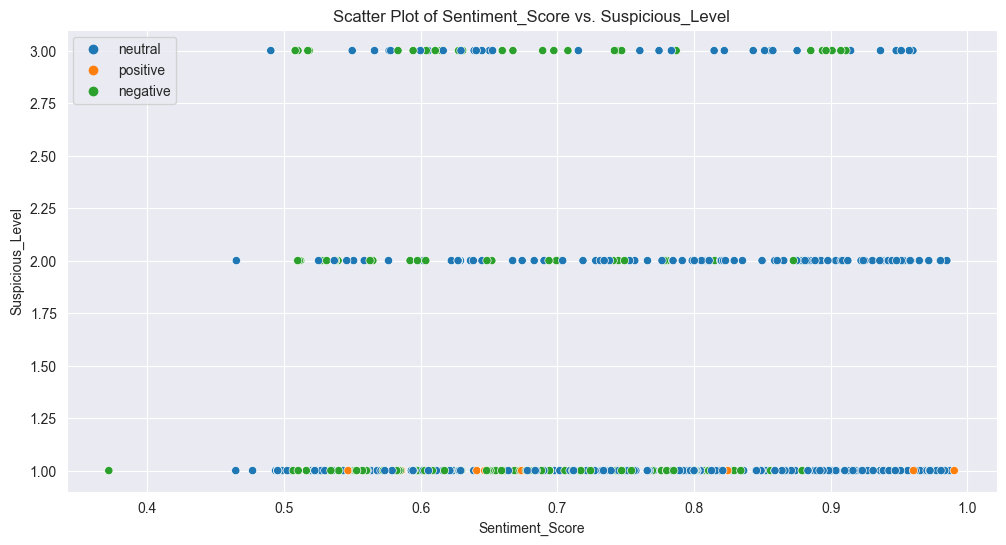

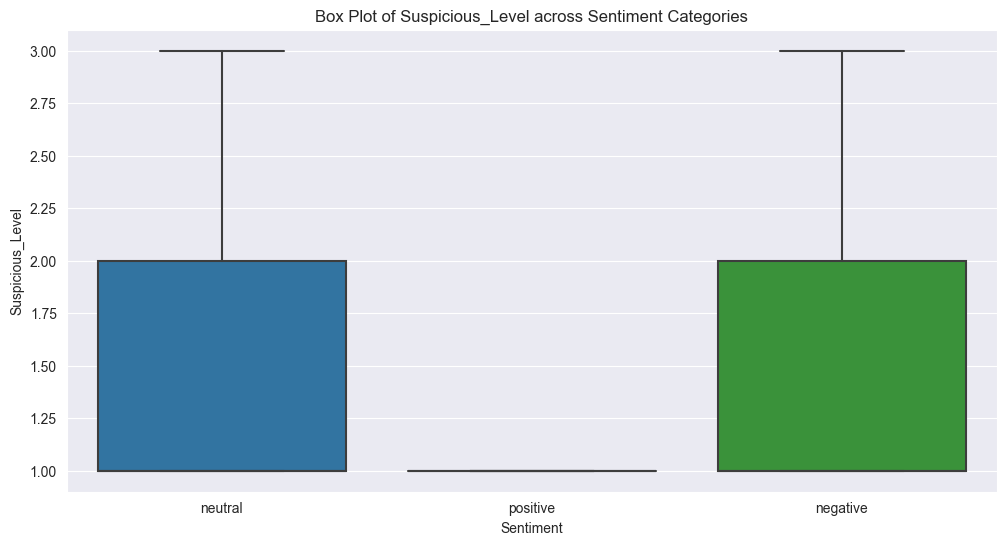

In [126]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Sentiment_Score', y='Suspicious_Level', hue='Sentiment', data=train_df)
plt.title('Scatter Plot of Sentiment_Score vs. Suspicious_Level')
plt.xlabel('Sentiment_Score')
plt.ylabel('Suspicious_Level')
plt.legend()
plt.show()

# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sentiment', y='Suspicious_Level', data=train_df)
plt.title('Box Plot of Suspicious_Level across Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Suspicious_Level')
plt.show()

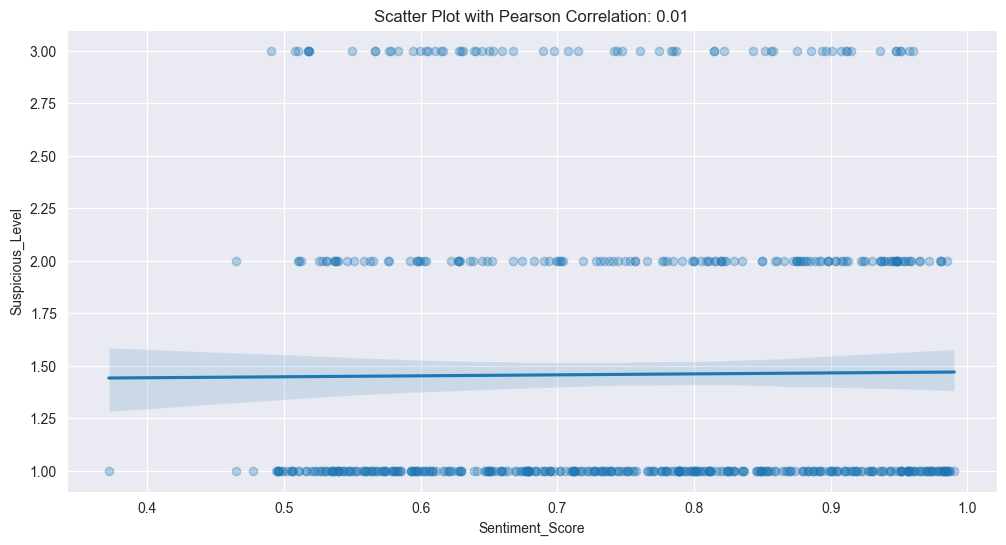

In [127]:
# Pearson

# Calculate Pearson correlation coefficient
pearson_corr = train_df[['Sentiment_Score', 'Suspicious_Level']].corr(method='pearson').iloc[0, 1]

# Scatter plot with regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='Sentiment_Score', y='Suspicious_Level', data=train_df, scatter_kws={'alpha':0.3})
plt.title(f'Scatter Plot with Pearson Correlation: {pearson_corr:.2f}')
plt.xlabel('Sentiment_Score')
plt.ylabel('Suspicious_Level')
plt.show()

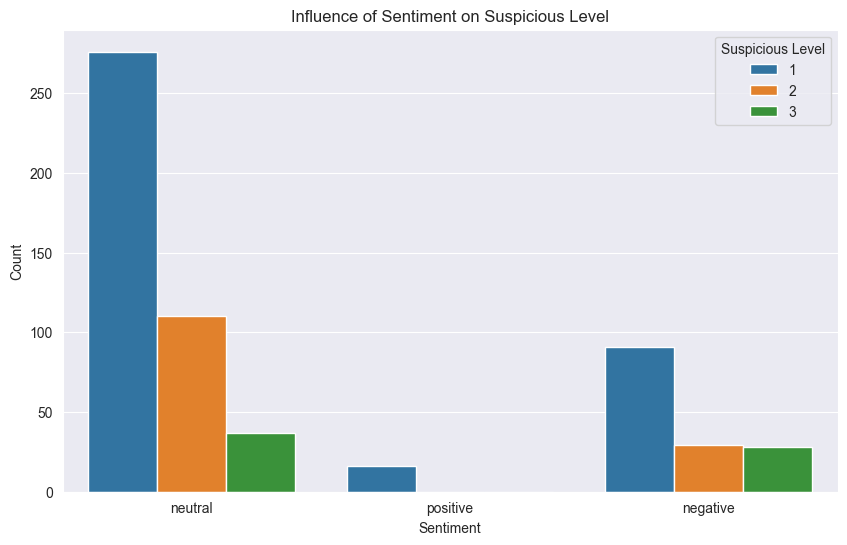

In [129]:
# Assuming 'train_df' is a DataFrame with 'Sentiment' and 'Suspicious_Level' columns
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', hue='Suspicious_Level', data=train_df)
plt.title('Influence of Sentiment on Suspicious Level')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Suspicious Level')
plt.show()

In [133]:
# Assuming you have already created 'num_sensitive' and 'Suspicious_Level' columns in train_df
correlation = train_df['Sentiment_Score'].corr(train_df['Suspicious_Level'], method='spearman')

print(f"Correlation between num_sensitive and Suspicious_Level: {correlation}")

Correlation between num_sensitive and Suspicious_Level: 0.03036837523070803


In [135]:
import scipy.stats as stats

contingency_table = pd.crosstab(train_df["Sentiment"], train_df["Suspicious_Level"])

print("Contingency Table:")
print(contingency_table)

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print("\nChi-square statistic:", chi2)
print("P-value:", p)

Contingency Table:
Suspicious_Level    1    2   3
Sentiment                     
negative           91   29  28
neutral           276  110  37
positive           16    0   0

Chi-square statistic: 21.145817219133807
P-value: 0.0002962693036616617


## Emotion

In [138]:
# Use a pipeline as a high-level helper
from transformers import pipeline

emotion_analyzer = pipeline("text-classification", model="seara/rubert-base-cased-ru-go-emotions")

In [139]:
# Function to predict sentiment
def predict_emotion(text):

    truncated_text = text[:512]

    # Make the prediction using the pipeline
    result = emotion_analyzer(truncated_text)

    # Extract the predicted label
    predicted_label = result[0]['label']
    sentiment_score = result[0]['score']

    return {'Emotion': predicted_label, 'Emotion_Score': sentiment_score}


In [140]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
predictions = train_df['Content'].apply(predict_emotion)

train_df['Emotion'] = predictions.apply(lambda x: x['Emotion'])
train_df['Emotion_Score'] = predictions.apply(lambda x: x['Emotion_Score'])

In [141]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score,Emotion,Emotion_Score
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454,neutral,0.745498
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936,gratitude,0.868692
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1,neutral,0.973560,neutral,0.906539
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272


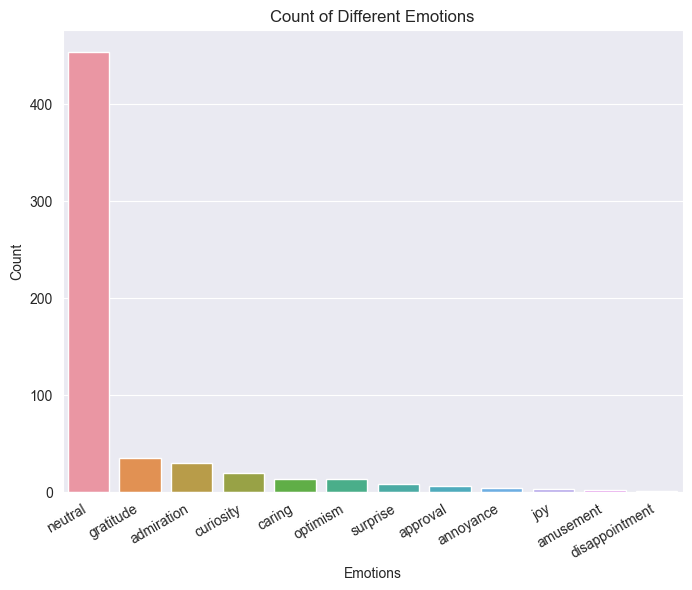

In [144]:
# Assuming 'train_df' is a DataFrame with 'Sentiment' column
emotions_counts = train_df['Emotion'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=train_df, order=emotions_counts.index)
plt.title('Count of Different Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')
plt.show()

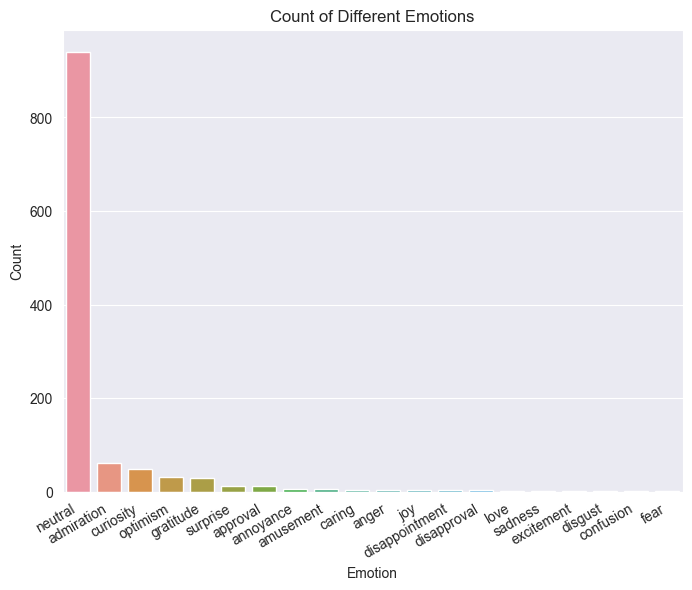

In [147]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
test_emotion_predictions = test_df['Content'].apply(predict_emotion)

# Extract 'Sentiment' and 'Sentiment_Score' into separate columns
test_df['Emotion'] = test_emotion_predictions.apply(lambda x: x['Emotion'])
test_df['Emotion_Score'] = test_emotion_predictions.apply(lambda x: x['Emotion_Score'])



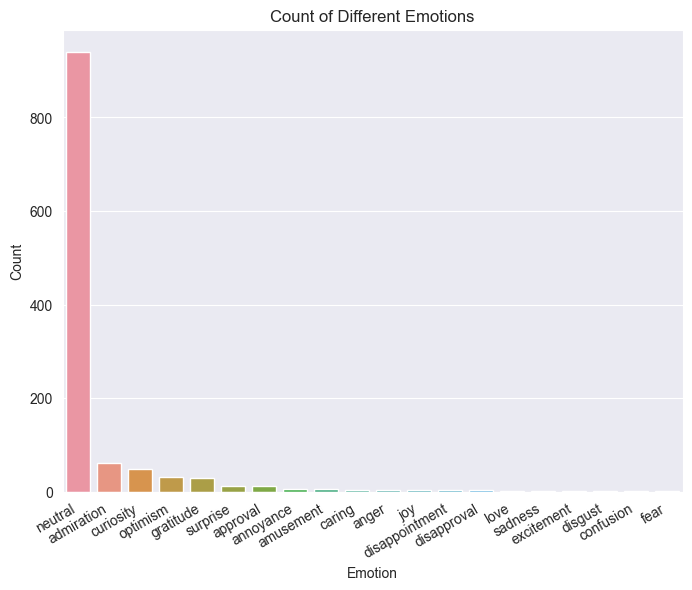

In [149]:
# Assuming 'train_df' is a DataFrame with 'Sentiment' column
test_emotion_counts = test_df['Emotion'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=test_df, order=test_emotion_counts.index)
plt.title('Count of Different Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()

In [150]:
contingency_table = pd.crosstab(train_df["Emotion"], train_df["Suspicious_Level"])

print("Contingency Table:")
print(contingency_table)

chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print("\nChi-square statistic:", chi2)
print("P-value:", p)

Contingency Table:
Suspicious_Level    1    2   3
Emotion                       
admiration         22    4   3
amusement           2    0   0
annoyance           1    1   2
approval            5    1   0
caring             13    0   0
curiosity           9    6   4
disappointment      0    0   1
gratitude          34    1   0
joy                 3    0   0
neutral           276  125  53
optimism           13    0   0
surprise            5    1   2

Chi-square statistic: 58.9033986495491
P-value: 3.242173602919448e-05


In [154]:
# Assuming you have already created 'num_sensitive' and 'Suspicious_Level' columns in train_df
correlation = train_df['Emotion_Score'].corr(train_df['Suspicious_Level'], method='spearman')

print(f"Correlation between num_sensitive and Suspicious_Level: {correlation}")

Correlation between num_sensitive and Suspicious_Level: 0.15472226335021547


## Dangerous text

In [156]:
from transformers import AutoConfig

dangerous_model_path = 'marianna13/xlm-roberta-fine-tuned-on-russian-abusive-language'

id2label = {
    0:'неопасный тескт',
    1:'опасный тескт'
}

label2id = {
    'неопасный тескт':0,
    'опасный тескт':1
}
dangerous_text_config = AutoConfig.from_pretrained(dangerous_model_path, id2label=id2label, label2id=label2id)
dangerous_text_tokenizer = AutoTokenizer.from_pretrained(dangerous_model_path)

dangerous_text_model = AutoModelForSequenceClassification.from_pretrained(dangerous_model_path, config=dangerous_text_config)

dangerous_text_analyzer = pipeline('text-classification', model=dangerous_text_model, tokenizer=dangerous_text_tokenizer)


In [157]:
text = "Прекрасный день."
dangerous_text_analyzer(text)

[{'label': 'неопасный тескт', 'score': 0.9637081027030945}]

In [161]:
# Function to predict dangerous text
def predict_danger(text):

    truncated_text = text[:512]

    # Make the prediction using the pipeline
    result = dangerous_text_analyzer(truncated_text)

    # Extract the predicted label
    predicted_label = True if result[0]['label']=='опасный текст' else False
    score = result[0]['score']

    return {'Dangerous': predicted_label, 'Dangerous_Score': score}

In [162]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
predictions = train_df['Content'].apply(predict_danger)

train_df['Dangerous'] = predictions.apply(lambda x: x['Dangerous'])
train_df['Dangerous_Score'] = predictions.apply(lambda x: x['Dangerous_Score'])

In [163]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score,Emotion,Emotion_Score,Dangerous,Dangerous_Score
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454,neutral,0.745498,False,0.913780
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936,gratitude,0.868692,False,0.948626
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1,neutral,0.973560,neutral,0.906539,False,0.940683
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768


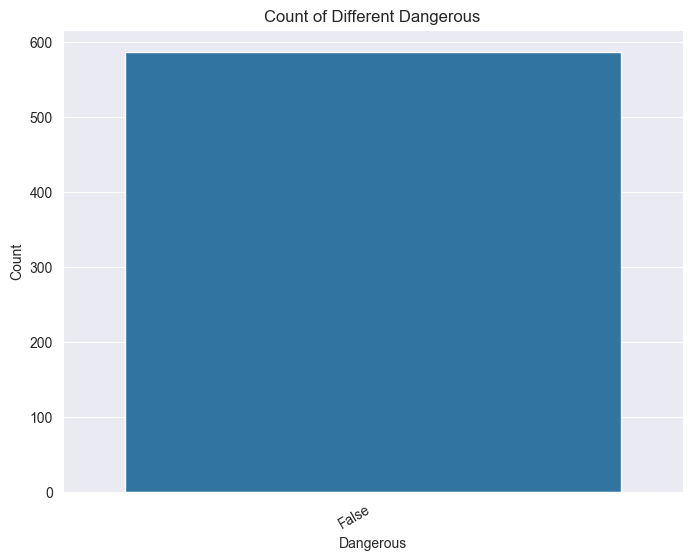

In [165]:
# Assuming 'train_df' is a DataFrame with 'Sentiment' column
dangerous_counts = train_df['Dangerous'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Dangerous', data=train_df, order=dangerous_counts.index)
plt.title('Count of Different Dangerous')
plt.xlabel('Dangerous')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')
plt.show()

In [166]:
# Example usage:
# Assuming 'train_df' is a DataFrame with a 'Content' column
predictions = test_df['Content'].apply(predict_danger)

test_df['Dangerous'] = predictions.apply(lambda x: x['Dangerous'])
test_df['Dangerous_Score'] = predictions.apply(lambda x: x['Dangerous_Score'])

In [170]:
# Assuming 'test_df' is a DataFrame that you want to save to a CSV file
test_df.to_csv(os.path.join(ROOT_DIR, 'test_extended.csv'), index=False)
train_df.to_csv(os.path.join(ROOT_DIR, 'train_extended.csv'), index=False)